We have been mostly concerned with the different datatypes and their impact on performance when querying tables. In this file, we will evaluate the performance on loading and extracting data to and from Postgres tables.

We will continue to work on the IGN reviews dataset that contains reviews from games. This dataset is stored in the `ign (1).csv` file. This file was modified to match the table that we created before — the last three columns representing the release date have been merged into one. As a refresher, here are the first few rows:

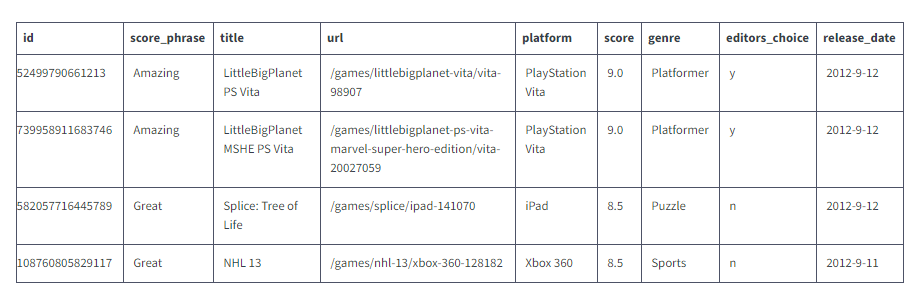

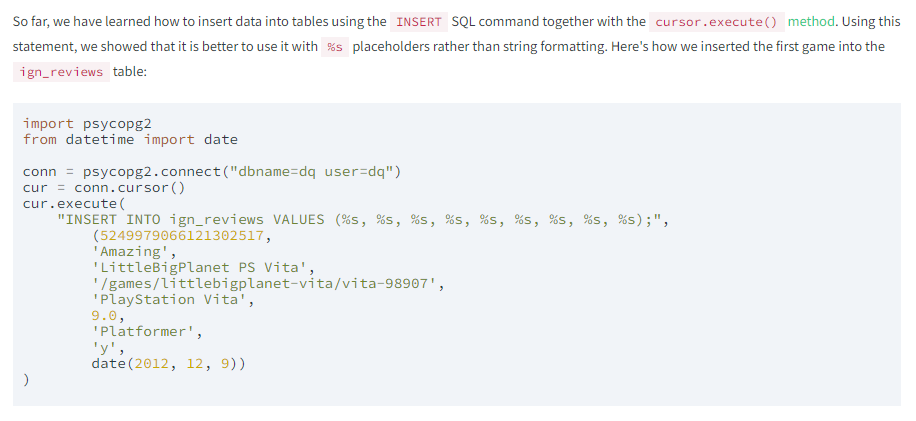

When placeholders are used in the `cursor.execute()` method, Python types are automatically and safely converted into Postgres types. The conversion takes place in a separate step using a method from the cursor object called [cursor.mogrify()](https://www.psycopg.org/docs/cursor.html#cursor.mogrify).

The following diagram illustrates how when we call the execute method, this method will use the mogrify method to replace the values into the given query string:

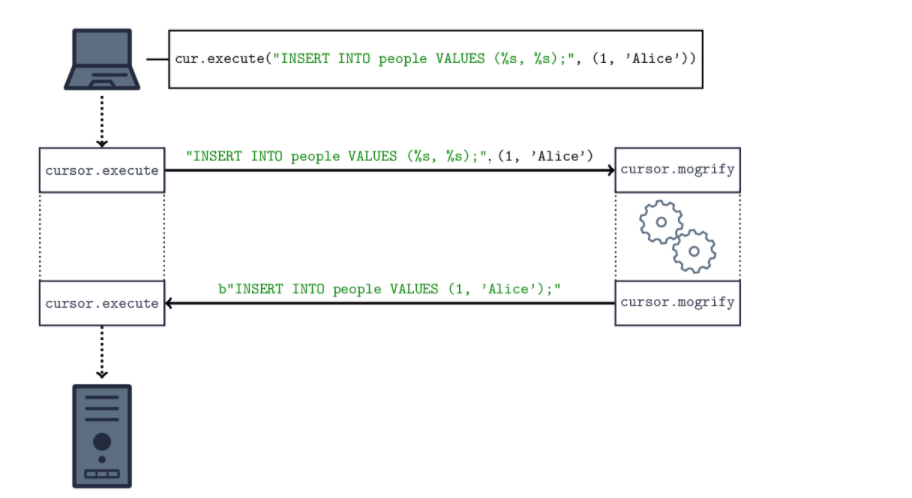

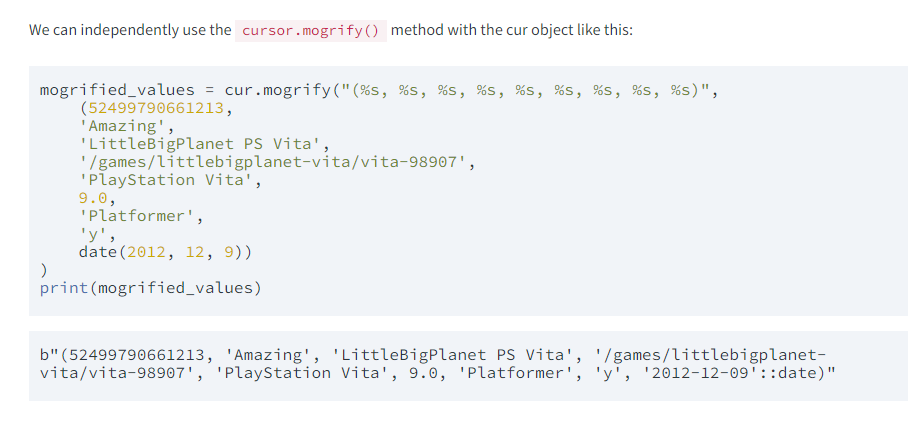

As we can see, the syntax is the same as when we execute a query. We pass a string as the first argument with placeholders for the values, and then we pass the values to replace as the second argument. However, this does not interact with the database in any way. It simply returns the result of replacing the values into the given string template.

**Task**

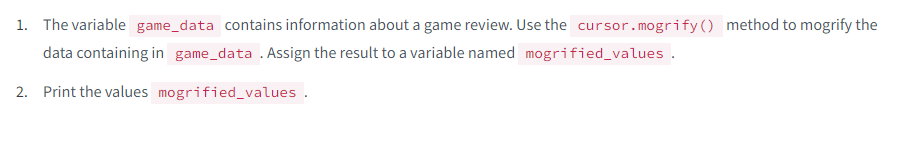

**Answer**

`from datetime import date
import psycopg2`

`conn = psycopg2.connect("dbname=dq user=dq")
cur = conn.cursor()`

`game_data = (52499790661213, 'Amazing', 'LittleBigPlanet PS Vita', 
'/games/littlebigplanet-vita/vita-98907', 'PlayStation Vita', 9.0, 'Platformer', 
'y', date(2012, 12, 9))`

`mogrified_values = cur.mogrify("(%s, %s, %s, %s, %s, %s, %s, %s, %s)", game_data)
print(mogrified_values)`

We may expect the output of the `cursor.mogrify()` method to be a string with the placeholders replaced by the given values. However, if we look carefully at the output above we see that there is a `b` as a prefix.

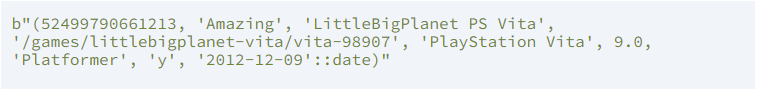

This indicates that the output is a [bytes object](https://docs.python.org/3/library/stdtypes.html#bytes-objects). In order to convert a `bytes` object into a string, we need to use the [`bytes.decode()` method](https://docs.python.org/3/library/stdtypes.html#bytes.decode) by passing the encoding used on the `bytes` object.

We can get the encoding used by a connection by accessing the [`connection.encoding` attribute](https://www.psycopg.org/docs/connection.html#connection.encoding):

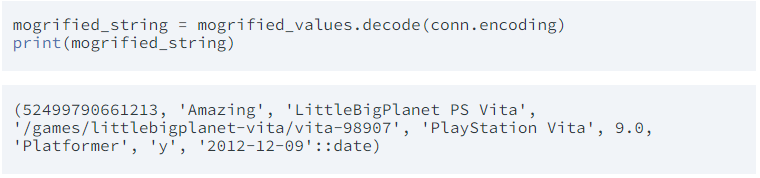

The value of the encoding depends on several factors such as the OS that we are using to connect. We can change the encoding used by calling the [`connection.set_client_encoding()` method](https://www.psycopg.org/docs/connection.html#connection.set_client_encoding). The set of possible arguments can be found in the [Postgres character set support documentation](https://www.postgresql.org/docs/current/multibyte.html).

Let's check what encoding does the connection use and redo the previous exercise but this time let's also decode the result into a string.

**Task**

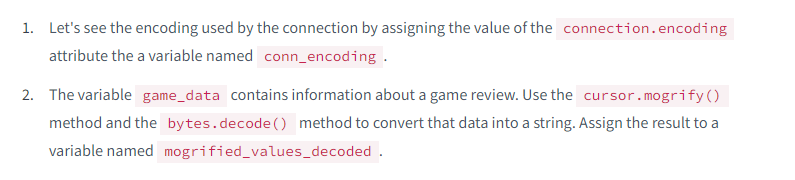

**Answer**

`from datetime import date
import psycopg2`

`conn = psycopg2.connect("dbname=dq user=dq")
cur = conn.cursor()`

`game_data = (52499790661213, 'Amazing', 'LittleBigPlanet PS Vita', 
'/games/littlebigplanet-vita/vita-98907', 'PlayStation Vita', 9.0, 'Platformer', 
'y', date(2012, 12, 9))`

`conn_encoding = conn.encoding
mogrified_values_decoded = cur.mogrify("(%s, %s, %s, %s, %s, %s, %s, %s, %s)", game_data).decode(conn_encoding)`

`print(conn_encoding)
print(mogrified_values_decoded)`

Above we discussed the `cursor.mogrify()` method which is what the `cursor.execute()` method uses to convert Python types into Postgres types when we pass the values as a second argument. We have seen this conversion happen when we mogrified the game data:

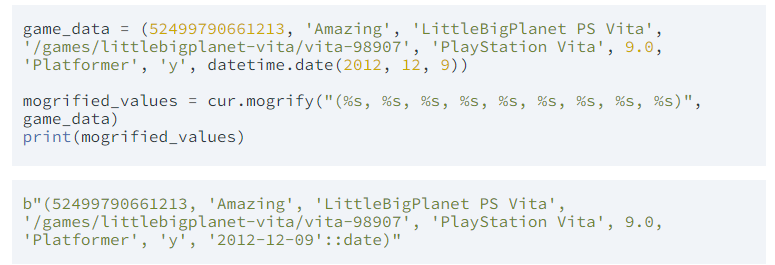

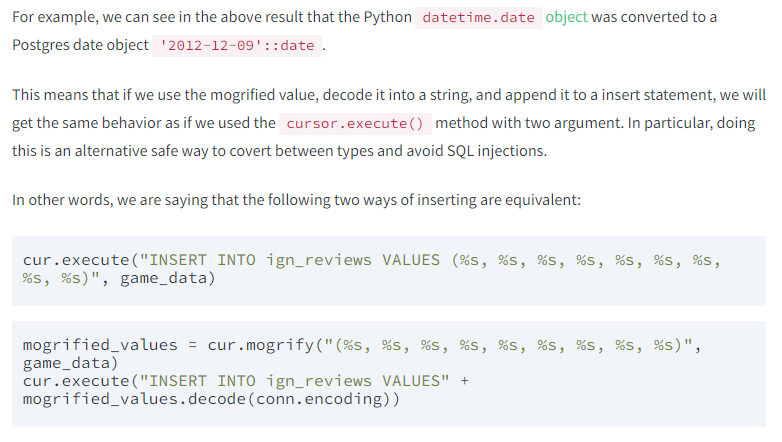

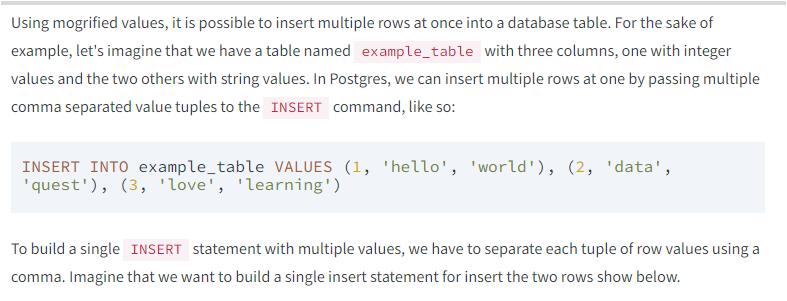

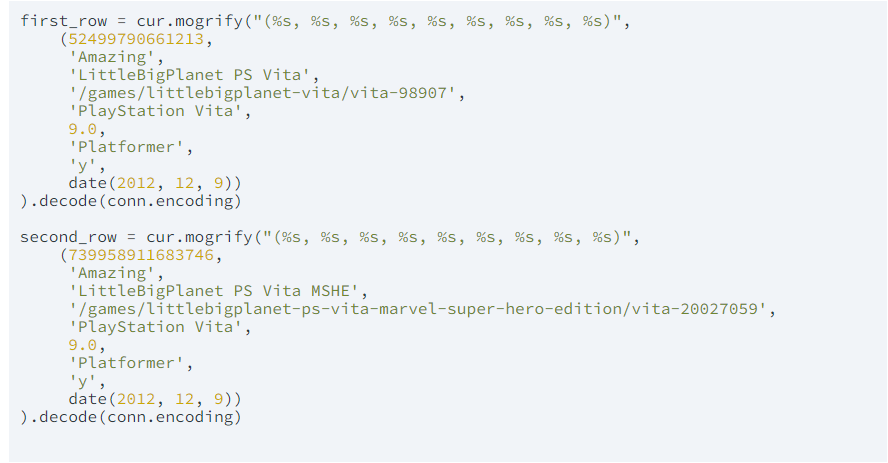

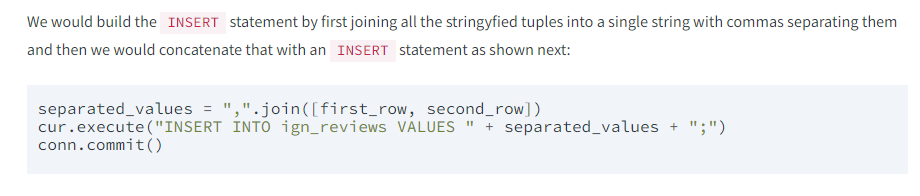

Let's building a query for inserting all rows from the `ign.csv` file at once!

**Task**

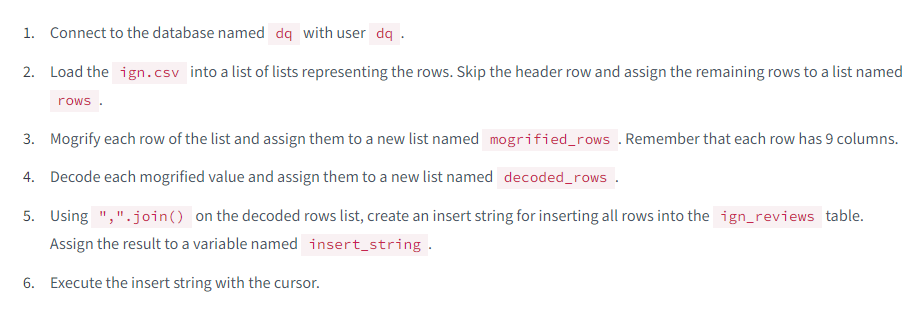

**Answer**

`import csv
import psycopg2
conn = psycopg2.connect("dbname=dq user=dq")
cur = conn.cursor()`

`with open("ign.csv", "r") as f:
    next(f)
    reader = csv.reader(f)
    rows = [row for row in reader]
    mogrified_rows = [cur.mogrify("(%s, %s, %s, %s, %s, %s, %s, %s, %s)", row) for row in rows]
    decoded_rows = [row.decode(conn.encoding) for row in mogrified_rows]
    insert_string = ",".join(decoded_rows)
    cur.execute("INSERT INTO ign_reviews VALUES " + insert_string + ";")
    conn.commit()
    conn.close()`

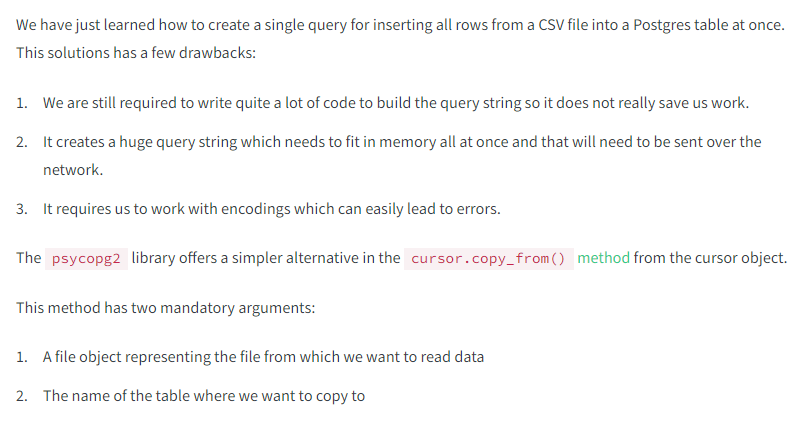

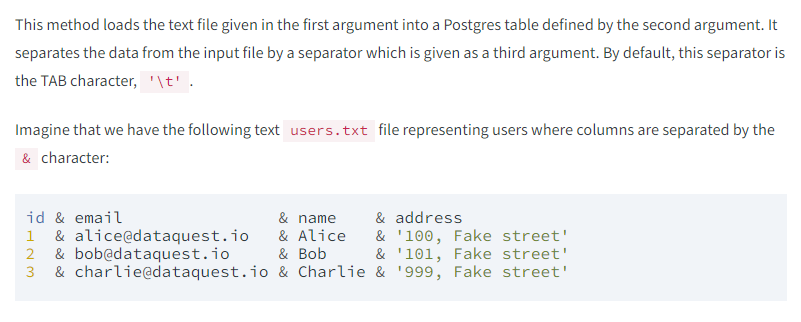

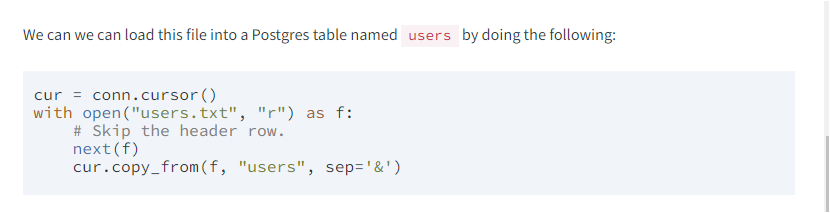

Note that we had to change the default separator to `&`.

**Task**

Load the `ign (1).csv` file into the `ign_reviews` table using the `cursor.copy_from()` method. Make sure to choose the proper column separator.

**Answer**

Above we introduced the `cursor.copy_from()` method, which copies a text file into a Postgres table. This method provides a useful way for file copying but it only works if the file is defined with a simple separator (delimiter) character like such as, for instance, commas.

Sure, we could argue that any CSV falls into this category so that this method is suitable for copying CSV files. However, there are caveats we must be aware of. CSV files can contain text entries that include a comma in the text where the row does not separate. For example, the text file from previous file as a CSV would look like:

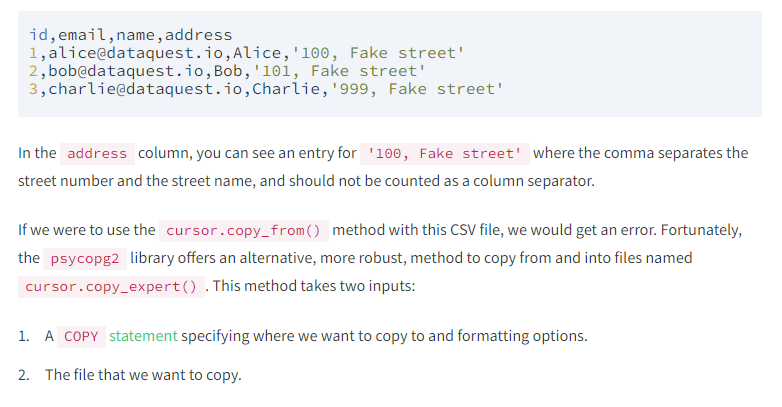

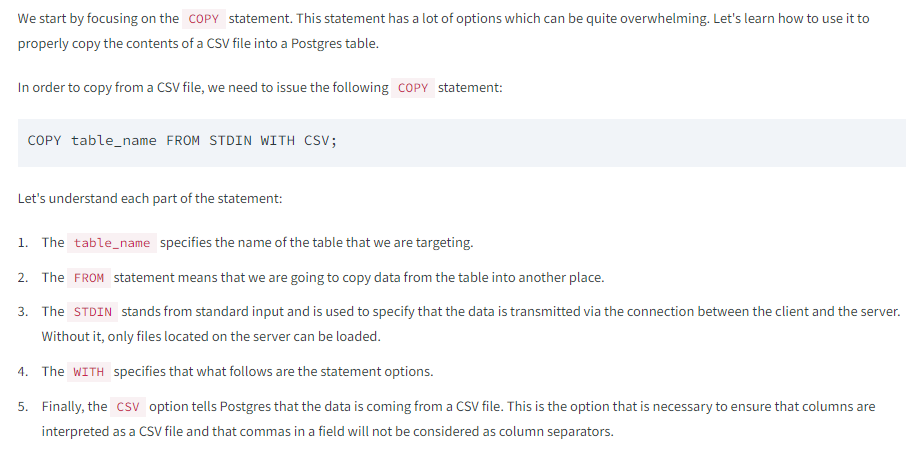

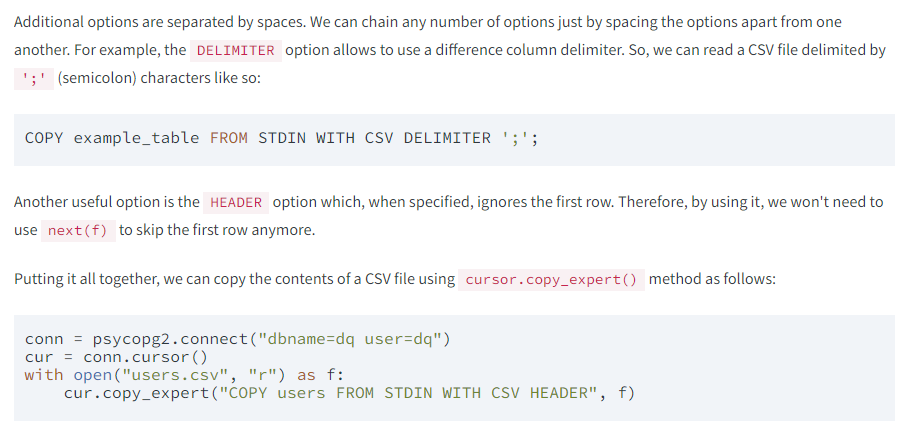

**Task**

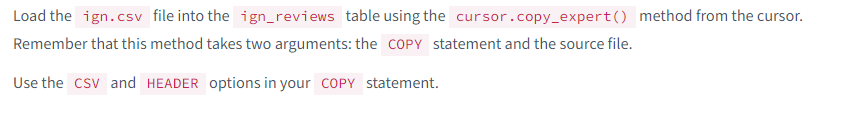

**Answer**

Using the `timeit` module determine which of the methods for loading a CSV into a Postgres table is the fastest. The code first measures the time required when executing multiple inserts as we learned in the earlier files, then the time for a single insert using the `cursor.mogrify()` method and finally the time to insert using the `cursor.copy_expert()` method.

The goal here is to get a sense at which method is the fastest. However, keep in mind that speed is not always the most important factor. Just because a method is faster does not mean it the best method for our needs. Sometimes the fastest method is not the most adaptable, and if we need to do some data transformation in our code, we might want to use `INSERT` over the `COPY`.

Between each test we use the [`connection.rollback()` method](https://www.psycopg.org/docs/connection.html#connection.rollback) from the connection object. If we remember, changes that are made into the database are put together into a transaction block that is then executed together when the `connection.commit()` method is called. The `connection.rollback()` method is used to ignore the current transaction block. It is useful for when we make a mistake in a query

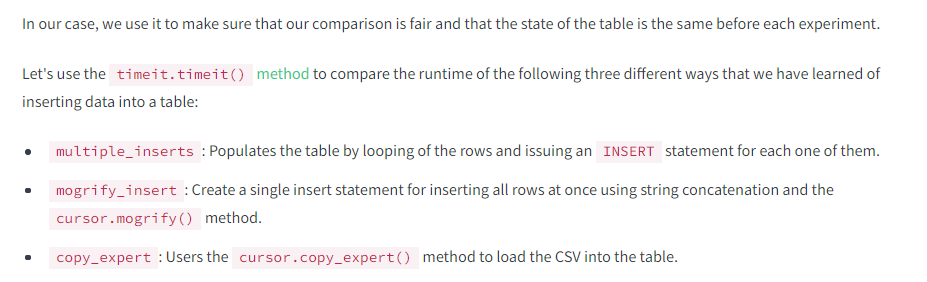

Recall that we can use the `timeit.timeit()` method to time one execution of a function as follows:

`timeit.timeit(function_name, number=1)`

**Task**

The three functions have been provided.

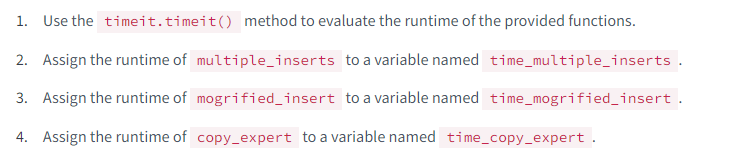

**Answer**

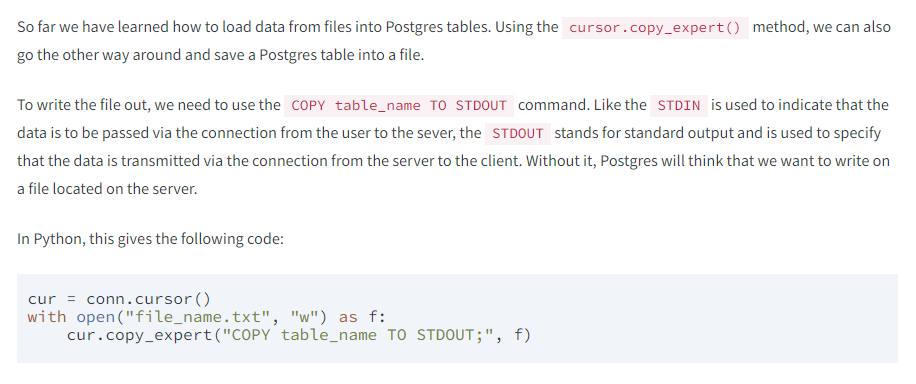

**Task**

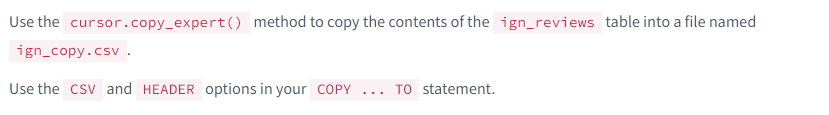

**Answer**

`import psycopg2
conn = psycopg2.connect("dbname=dq user=dq")
cur = conn.cursor()
with open("ign_copy.csv", "w") as f:
    cur.copy_expert("COPY ign_reviews TO STDOUT WITH CSV HEADER;", f)
    conn.close()`

So far we have covered most ways of transferring data between files and database tables. Now we are going to cover ways to transfer data between two tables.

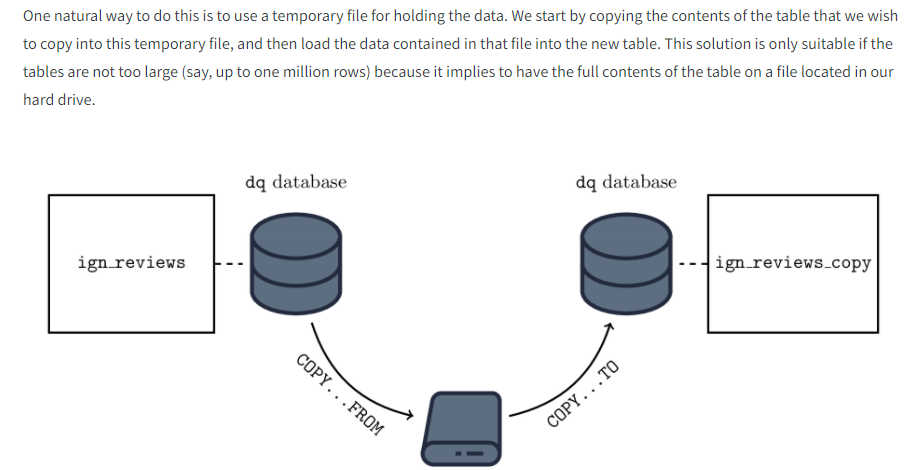

Nevertheless, this is a great exercise for us to practice since it involves handling the two main concepts of saving a table into CSV file and loading CSV file into a table.

**Task**

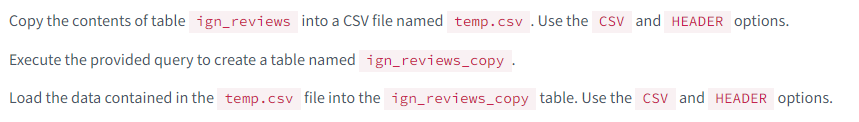

**Answer**

`import psycopg2`

`# the query to create the empty table copy`

`create_string = """`

`CREATE TABLE ign_reviews_copy (
    id bigint PRIMARY KEY,
    score_phrase evaluation_enum,
    title varchar(200),
    url varchar(200),
    platform platform_enum,
    score decimal(3, 1),
    genre genre_enum,
    editors_choice boolean,
    release_date date
);
"""`

`conn = psycopg2.connect("dbname=dq user=dq")
cur = conn.cursor()`

`# copy the table into the CSV file`

`with open("temp.csv", "w") as f:
    cur.copy_expert("COPY ign_reviews TO STDOUT WITH CSV HEADER;", f)`

`# create the new table`

`cur.execute(create_string)`

`# load the CSV file into the new table`

`with open("temp.csv", "r") as f:
    cur.copy_expert("COPY ign_reviews_copy FROM STDIN WITH CSV HEADER;", f)`
    
`conn.commit()
conn.close()`

Above we saw that we could copy the contents of a table into a newly created table using Python and the `cursor.copy_expert()` method. This approach is great for tables that contain less than a million rows, but as the size of the table increases, it becomes unlikely that this approach would work, because it requires to store the temporary file in the client's hard drive.

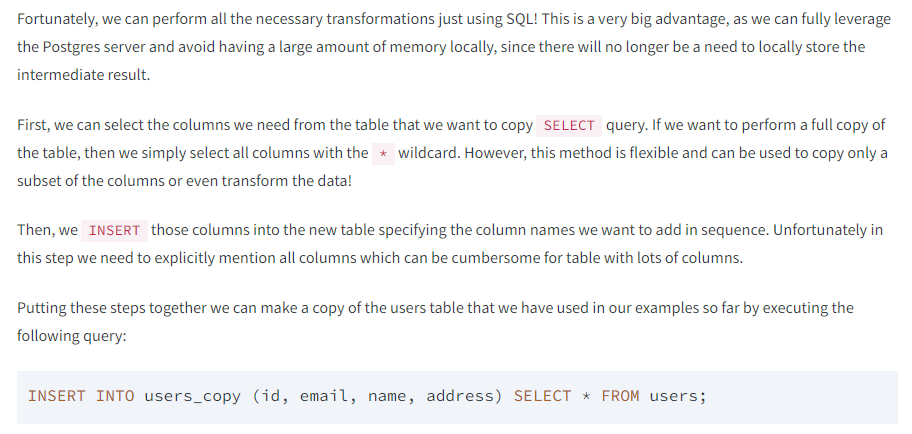

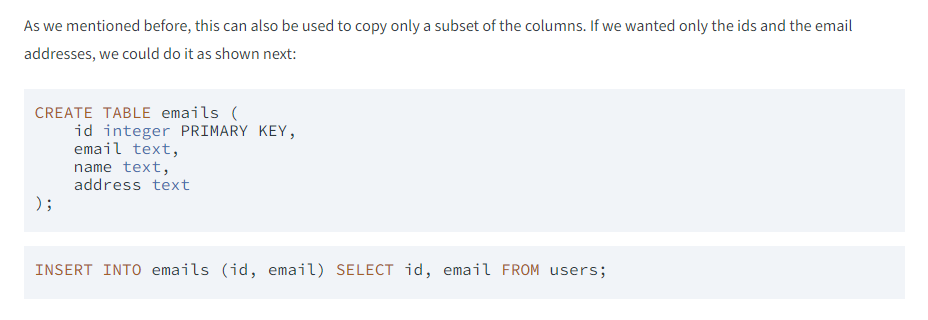

**Task**

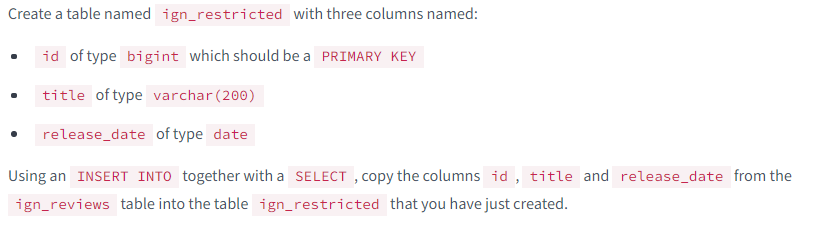

**Answer**

`import psycopg2
conn = psycopg2.connect("dbname=dq user=dq")
cur = conn.cursor()`

`cur.execute("""
    CREATE TABLE ign_restricted (
        id bigint PRIMARY KEY, 
        title varchar(200),
        release_date date
    );
""")`

`cur.execute("""
    INSERT INTO ign_restricted (id, title, release_date) SELECT id, title, release_date FROM ign_reviews;
""")`

`conn.commit()
conn.close()`

In this file, we learned:

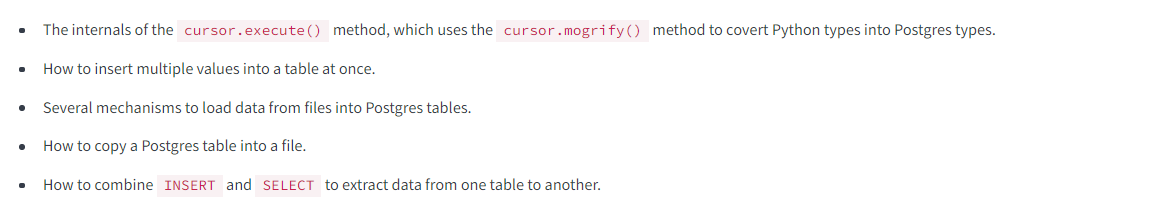

In the next file, we will explore the user management side of Postgres to connect to other databases with different users.

This is an important skill to have in a real system, since those normally have a lot of different users that need to interact with the database, and not all of them require the same privileges. Being able to define the correct roles is a necessary step in making the data available to everyone that is intended to interact with it.